# Validate Generation Model

Show good fit of network properties between simulated and real graphs. We check here both published and enumerated graphs

In [7]:
import sys; sys.path.append("../")
from src.GeneratingModels import PreferentialAttachmentModel
from src import constants
from src.SimulatedReactionGraph import SimulatedReactionGraph
from src.NasaPolynomial import NasaPolynomial
import torinanet as tn
from typing import Union
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sqlite3
from openbabel import openbabel as ob
import json

GRAPH_PATHS = {
    "published": {
        "hydrogen": constants.BASE_LITERATURE_GRAPH_PATH.replace("$", "hydrogen"),
        "ammonia": constants.BASE_LITERATURE_GRAPH_PATH.replace("$", "ammonia"),
        "methane": constants.BASE_LITERATURE_GRAPH_PATH.replace("$", "methane"),
    },
    "enumerated": {
        "hydrogen": os.path.join(constants.DATA_DIR, "enumerated", "raw", "hydrogen", "rxn_graph.rxn"),
        "ammonia": os.path.join(constants.DATA_DIR, "enumerated", "raw", "ammonia", "2", "crud_graph.rxn"),
    }
}

## Define Common Functions

In [8]:
def generate_synthetic_graphs(nspeices, nreactions, ngraphs, temperature: float=600):
    # make the base model
    model = PreferentialAttachmentModel(
        nspeices, 
        nreactions, 
        specie_energy_dist=constants.SPECIE_ENERGY_DIST
    )
    res = []
    for _ in range(ngraphs):
        g = model.generate_graph()
        g.add_kinetic_data(T=temperature)
        res.append(g)
    return res

def get_degrees(rxn_graph: Union[tn.core.RxnGraph, SimulatedReactionGraph]) -> pd.DataFrame:
    if isinstance(rxn_graph, tn.core.RxnGraph):
        g = rxn_graph.to_networkx_graph(use_internal_id=True)
        species = set(rxn_graph.specie_collection.keys())
        typer = lambda node: "s" if node in species else "r"
    else:
        g = rxn_graph.g
        typer = lambda node: "r" if "r" in node else "s"
    data = []
    for node in g.nodes:
        if node == "s0":
            continue
        ajr = {
            "type": typer(node),
            "in": len([x for x in g.predecessors(node) if not x == "s0"]),
            "out": len([x for x in g.successors(node) if not x == "s0"]),
            "total": len([x for x in g.predecessors(node) if not x == "s0"]) + len([x for x in g.successors(node) if not x == "s0"]),
        }
        data.append(ajr)
    return pd.DataFrame(data, index=[s for s in g.nodes if s != "s0"])

def collect_graphs(source: str, n_synthetic):
    ajr = {}
    for gname, path in GRAPH_PATHS[source].items():
        args = constants.RXN_GRAPH_PARAMS if source == "published" else None
        rxngraph = tn.core.RxnGraph.from_file(path, classargs=args)
        simulated = generate_synthetic_graphs(rxngraph.get_n_species(), rxngraph.get_n_reactions(), n_synthetic)
        ajr[gname] = {"real": rxngraph, "simulated": simulated}   
    return ajr

def get_reaction_properties(rxn_graph: Union[tn.core.RxnGraph, SimulatedReactionGraph], prop: str) -> list:
    if isinstance(rxn_graph, tn.core.RxnGraph):
        g = rxn_graph.to_networkx_graph(use_internal_id=True)
        rxns = rxn_graph.reaction_collection.keys()
    else:
        g = rxn_graph.g
        rxns = rxn_graph.get_reactions()
    func = lambda node: g.nodes[node]["obj"].properties.get(prop, None) if "obj" in g.nodes[node] else g.nodes[node].get(prop, None)
    ajr = []
    for rxn in rxns:
        k = func(rxn)
        if k is None:
            continue
        ajr.append(k)
    return ajr

# get energy functions

def get_energy(connection, smiles):
    l = connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()
    if len(l) > 0:
        return l[0][0]
    else:
        return None

def get_atomization_energy(connection, smiles: str, atom_energies: dict):
    if smiles is None:
        return None
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    e = get_energy(connection, smiles)
    if e is not None:
        return e - ajr
    else:
        return None

def add_atomization_energies(db_path: str, rxn_graph: tn.core.RxnGraph) -> tn.core.RxnGraph:
    """Method to update the species energies in the reaction graph from existing computations"""
    connection = sqlite3.connect(db_path)
    atom_energies = {
                     "H": get_energy(connection, "[H]"), 
                     "O": get_energy(connection, "[O]"), 
                     "C": get_energy(connection, "[C]"),
                     "N": get_energy(connection, "[N]")
                    }
    # adding data to species
    for specie in rxn_graph.species:
        smiles = specie.identifier 
        atomization_energy = get_atomization_energy(connection, smiles, atom_energies)
        if atomization_energy is not None:
            specie.properties["energy"] = atomization_energy * constants.Ha_TO_JMOL
    return rxn_graph

def add_specie_enthalpy(rxn_graph: tn.core.RxnGraph):
    for sp in rxn_graph.species:
        s = sp.properties["thermo"].replace("'", "\"")
        d = json.loads(s)
        poly = NasaPolynomial(**d)
        sp.properties["H"] = poly.h(constants.DEFAULT_TEMPERATURE)
    return rxn_graph
    

def add_reaction_energy(rxn_graph: tn.core.RxnGraph, energy_property: str) -> tn.core.RxnGraph:
    # adding data to reactions
    for rxn in rxn_graph.reactions:
        products_e = [s.properties.get(energy_property, None) for s in rxn.products]
        reactants_e = [s.properties.get(energy_property, None) for s in rxn.reactants]
        if None in products_e or None in reactants_e:
            continue
        rxn.properties["energy"]  = sum(products_e) - sum(reactants_e)
    return rxn_graph

# plotting functions

def specie_degree_distribution_plot(data: dict):
    """compare degree distributions of real and simulated graphs"""
    # compare specie degree distributions between real and simulated graphs
    fig, axs = plt.subplots(nrows=len(data), ncols=3, figsize=(15, 5 * len(data)))
    plt.tight_layout()
    i = 0
    for gname, nets in data.items():
        real_degrees = get_degrees(nets["real"])
        simulated_degrees = pd.concat([get_degrees(g) for g in nets["simulated"]])

        # filter out only specie degrees
        real_degrees = real_degrees[real_degrees["type"] == "s"]
        simulated_degrees = simulated_degrees[simulated_degrees["type"] == "s"]
        j = 0
        for degree_type in real_degrees.columns:
            if degree_type == "type":
                continue
            axs[i, j].hist(real_degrees[degree_type], alpha=0.5, label=f"Real", density=True)
            axs[i, j].hist(simulated_degrees[degree_type], alpha=0.5, label=f"Simulated", density=True)
            axs[i, j].legend()
            if i == 0:
                axs[i, j].set_title(f"{degree_type.title()} Degree")
            if j == 0:
                axs[i, j].set_ylabel(f"{gname.title()}")
            j += 1
        i += 1

def reaction_degree_distribution_plot(data: dict):
    # compare specie degree distributions between real and simulated graphs
    fig, axs = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))
    plt.tight_layout()
    i = 0
    for gname, nets in data.items():
        real_degrees = get_degrees(nets["real"])
        simulated_degrees = pd.concat([get_degrees(g) for g in nets["simulated"]])

        # filter out only specie degrees
        real_degrees = real_degrees[real_degrees["type"] == "r"]
        simulated_degrees = simulated_degrees[simulated_degrees["type"] == "r"]

        # add reaction type as str
        real_degrees["rxn"] = ["{} -> {}".format(r["in"], r["out"]) for r in real_degrees.to_dict("records")]
        simulated_degrees["rxn"] = ["{} -> {}".format(r["in"], r["out"]) for r in simulated_degrees.to_dict("records")]

        real = real_degrees["rxn"].value_counts() / len(real_degrees)
        simulated = simulated_degrees["rxn"].value_counts() / len(simulated_degrees)
        df = real.to_frame().merge(simulated, how="outer", left_index=True, right_index=True, suffixes=("_real", "_simulated"))
        ticks = np.arange(len(df.index))
        axs[i].bar(ticks - 0.2, df["count_real"], label=f"Real", width=0.4, align='center')
        axs[i].bar(ticks + 0.2, df["count_simulated"], label=f"Simulated", width=0.4, align='center')
        axs[i].set_title(gname.title())
        axs[i].set_xticks(ticks, df.index)
        axs[i].legend()
        i += 1

def compare_reaction_energy_distributions(data: dict):
    fig, axs = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))
    plt.tight_layout()
    i = 0
    for gname, nets in data.items():
        real_e = get_reaction_properties(nets["real"], "energy")
        simulated_e = []
        for g in nets["simulated"]:
            simulated_e.extend(get_reaction_properties(g, "energy"))
        # print(real_e[:10], simulated_e[:10])
        axs[i].plot()
        axs[i].hist(real_e, label=f"Real", alpha=0.5, density=True)
        axs[i].hist(simulated_e, label=f"Simulated", alpha=0.5, density=True)
        axs[i].set_title(gname.title())
        axs[i].legend()
        i += 1

def kinetic_property_distribution(data: dict, prop: str):
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
    plt.tight_layout()
    i = 0
    for gname, nets in data.items():
        real_e = get_reaction_properties(nets["real"], prop)
        simulated_e = []
        for net in nets["simulated"]:
            simulated_e.extend(get_reaction_properties(net, prop))
        axs[i].hist(np.clip(real_e, min(simulated_e), max(simulated_e)), label=f"Real", alpha=0.5, bins=50, density=True)
        axs[i].hist(simulated_e, label=f"Simulated", alpha=0.5, bins=50, density=True)
        axs[i].set_title(gname.title())
        axs[i].legend()
        axs[i].set_xlabel("log(k)")
        i += 1
    axs[0].set_ylabel("Density")

## Compare model to reality

collect data

In [13]:
source = "published"

data = collect_graphs(source, 10)

compare species and reaction degree distributions

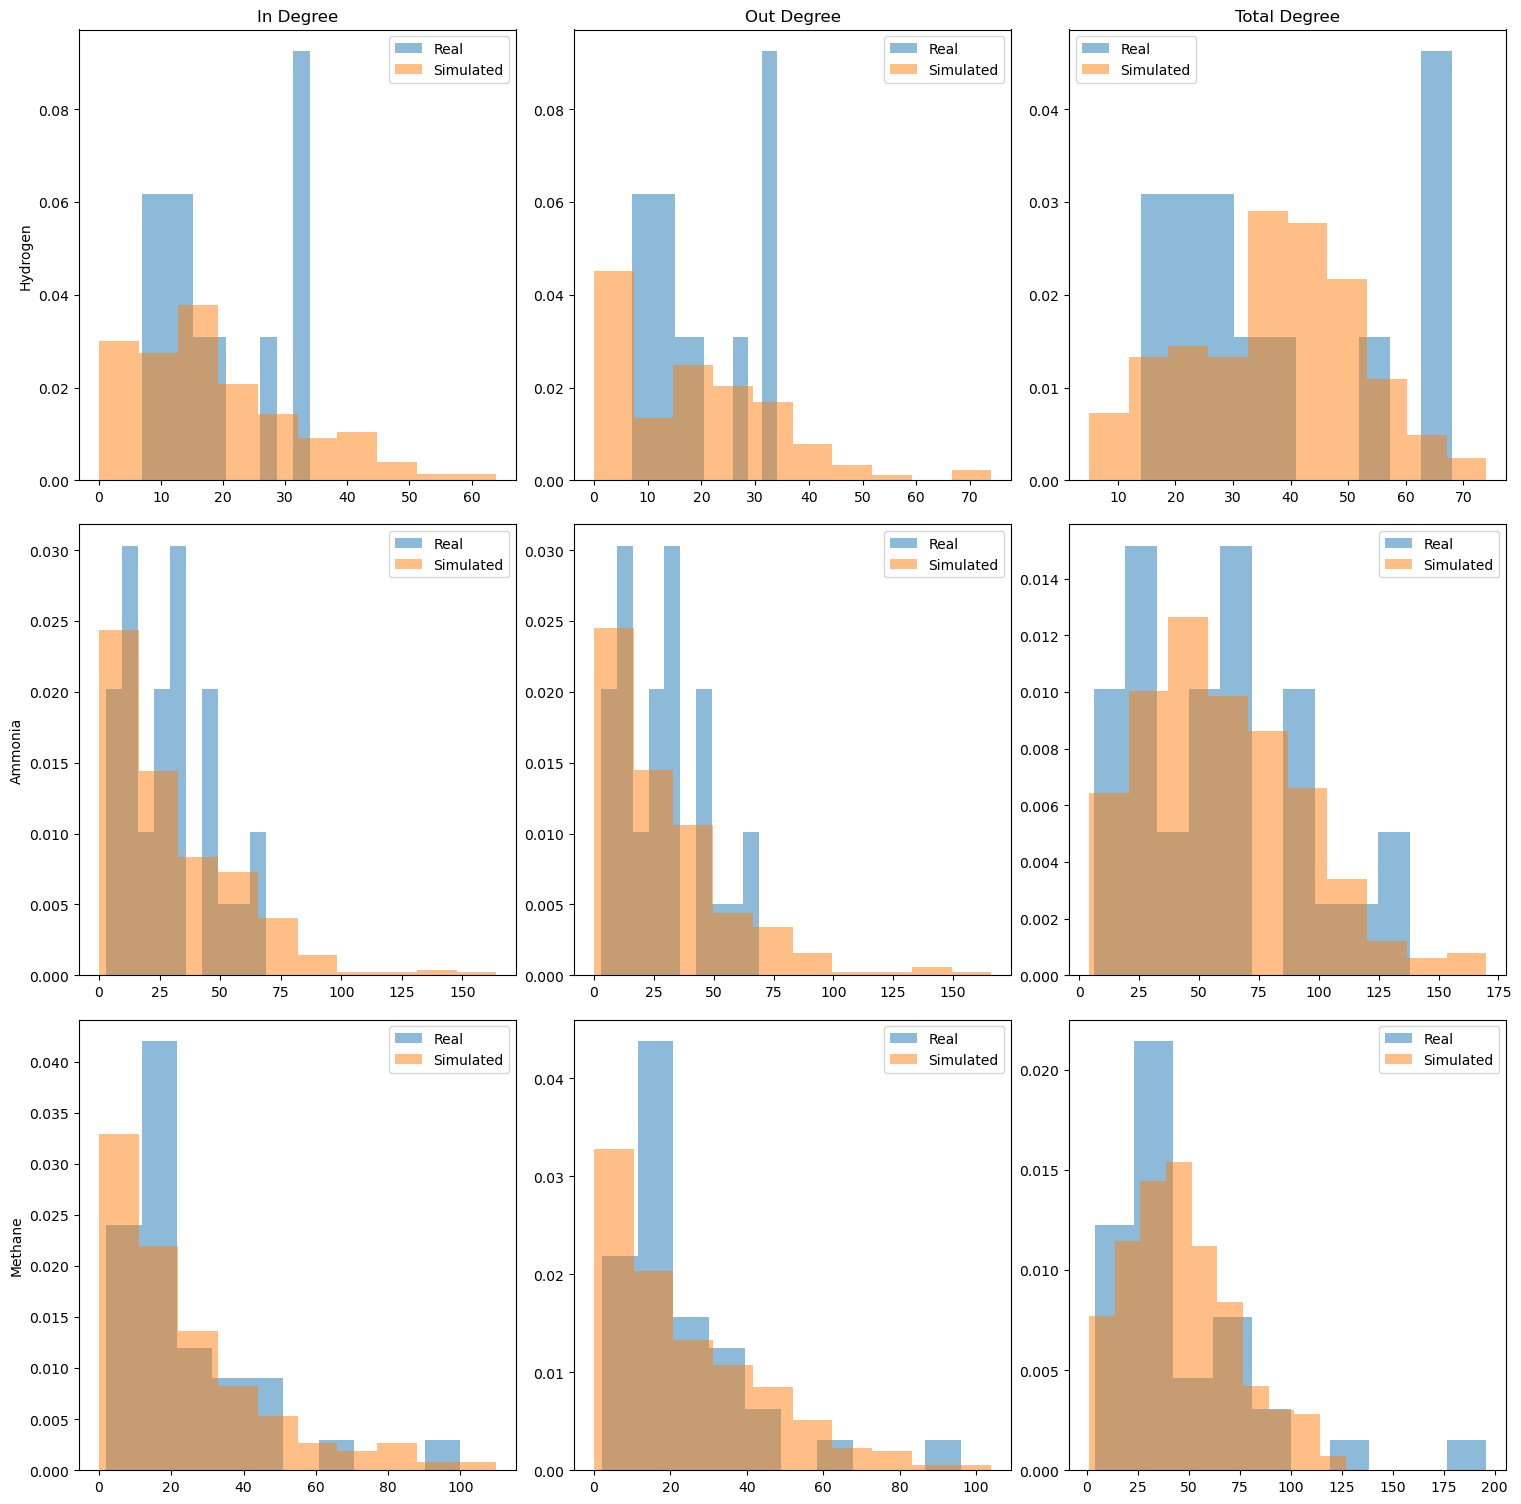

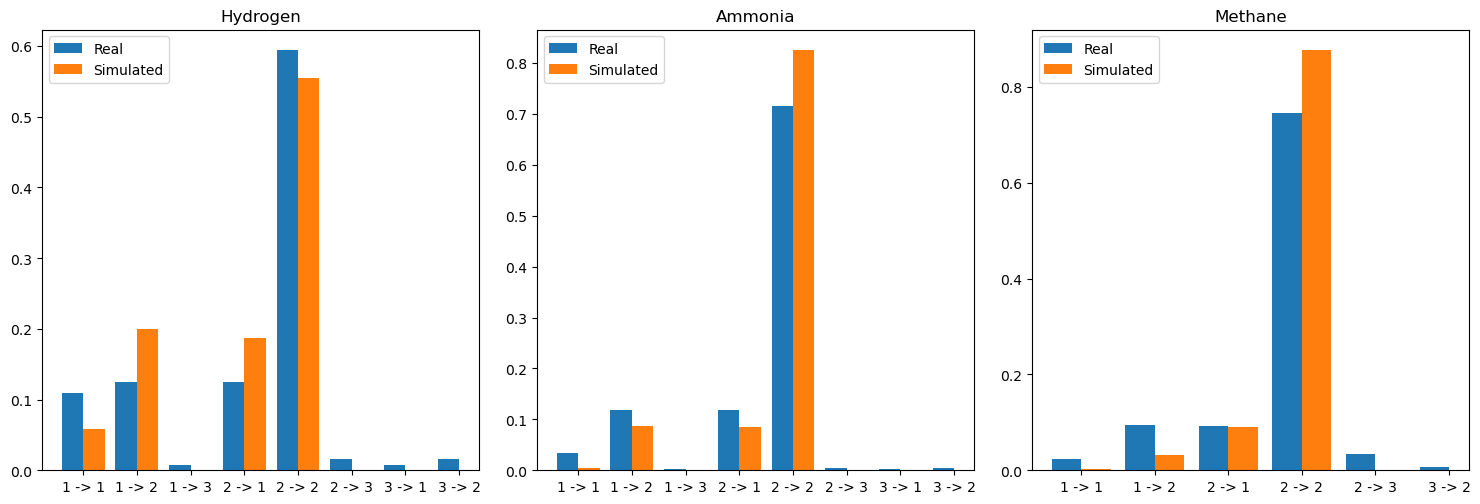

In [14]:
specie_degree_distribution_plot(data)
reaction_degree_distribution_plot(data)

compare reaction energy distribution

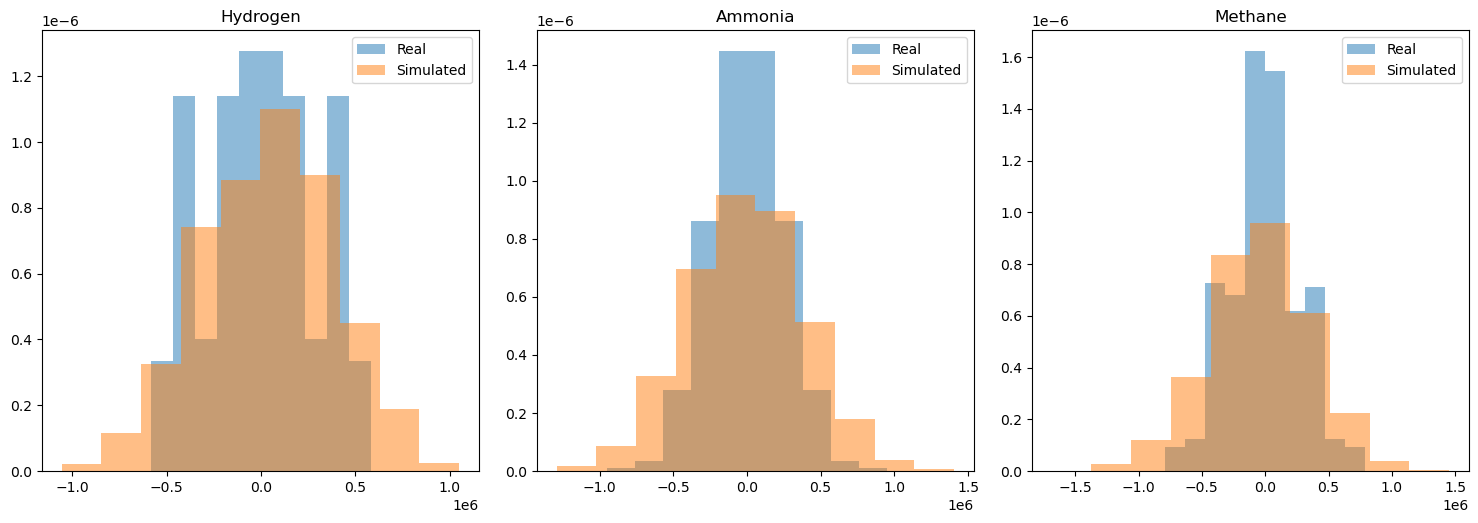

In [15]:
if source == "enumerated":
    for ajr in data.values():
        # if data source is real, we need to add atomization energy data from past calculations
        ajr["real"] = add_atomization_energies(os.path.join(constants.DATA_DIR, "joined.db"), ajr["real"])
        ajr["real"] = add_reaction_energy(ajr["real"], "energy")
else:
    for ajr in data.values():
        ajr["real"] = add_specie_enthalpy(ajr["real"])
        ajr["real"] = add_reaction_energy(ajr["real"], "H")
compare_reaction_energy_distributions(data)

compare rate constant data (only for published netwoks)

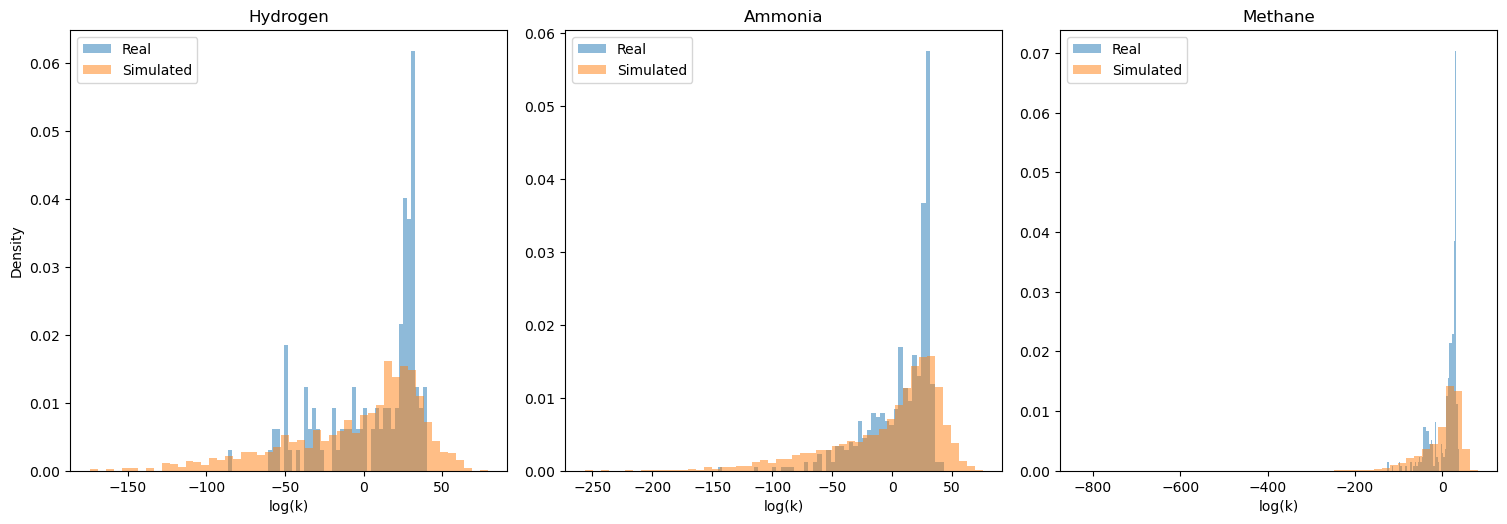

In [16]:
kinetic_property_distribution(data, "logk")